In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import array
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error


In [2]:
stock_apple = pd.read_csv('Apple_clean.csv')
stock_apple

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-12-31,7.611786,7.619643,7.520000,7.526071,6.326138,352410800
1,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.424604,493729600
2,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.435713,601904800
3,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.333343,552160000
4,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.321635,477131200
...,...,...,...,...,...,...,...
3977,2025-10-23,259.940002,260.619995,258.010010,259.579987,259.579987,32754900
3978,2025-10-24,261.190002,264.130005,259.179993,262.820007,262.820007,38253700
3979,2025-10-27,264.880005,269.119995,264.649994,268.809998,268.809998,44888200
3980,2025-10-28,268.989990,269.890015,268.149994,269.000000,269.000000,41461500


In [3]:
stock_apple['Date'] = pd.to_datetime(stock_apple['Date'])
stock_apple = stock_apple.set_index(pd.DatetimeIndex(stock_apple['Date'].values))
df_apple = pd.DataFrame(stock_apple, columns=['Close'])


In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
df_apple_scaled = scaler.fit_transform(np.array(df_apple).reshape(-1,1))

In [5]:
train_size = int(len(df_apple_scaled) * 0.6)
val_size = int(len(df_apple_scaled) * 0.2)
test_size = len(df_apple_scaled) - train_size - val_size

train_data = df_apple_scaled[:train_size]
val_data = df_apple_scaled[train_size:train_size+val_size]
test_data = df_apple_scaled[train_size+val_size:]

In [6]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100

In [7]:
train_last_window = train_data[-time_step:]
val_data_extended = np.concatenate((train_last_window, val_data), axis=0)
val_last_window = val_data[-time_step:]
test_data_extended = np.concatenate((val_last_window, test_data), axis=0)

X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data_extended, time_step)
X_test, y_test = create_dataset(test_data_extended, time_step)

In [8]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [9]:
from keras.layers import Input

model = Sequential()
# Dùng Input ở layer đầu tiên
model.add(Input(shape=(time_step, 1)))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

In [10]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,        # Số epoch bạn muốn train
    batch_size=32,    # batch size
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 4.5921e-04 - val_loss: 4.9636e-04
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 7.7444e-05 - val_loss: 4.2401e-04
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - loss: 5.1100e-05 - val_loss: 4.4738e-04
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - loss: 5.6223e-05 - val_loss: 3.9853e-04
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - loss: 4.3236e-05 - val_loss: 6.9539e-04
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - loss: 4.7285e-05 - val_loss: 3.3059e-04
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 4.4650e-05 - val_loss: 5.7014e-04
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - loss: 3.6299e-05 - val_loss: 4.4868e-04
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - loss: 3.8911e-05 - val_loss: 6.7331e-04
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 3.1860e-05 - val_loss: 4.3692e-04
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 3.203

In [11]:
y_pred_test = model.predict(X_test)
y_pred_val = model.predict(X_val)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


In [12]:
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
val_mse = mean_squared_error(y_pred_val, y_val)
val_rmse = np.sqrt(val_mse)
val_msle = mean_squared_log_error(y_pred_val, y_val)
print(f"Validation MAPE: {val_mape}")
print(f"Validation RMSE: {val_rmse}")
print(f"Validation MSLE: {val_msle}")

Validation MAPE: 0.02681503424589342
Validation RMSE: 0.015792802749680805
Validation MSLE: 0.00011467044935713265


In [13]:
test_mape = mean_absolute_percentage_error(y_pred_test, y_test)
test_mse = mean_squared_error(y_pred_test, y_test)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_pred_test, y_test)
print(f"Test MAPE: {test_mape}")
print(f"Test RMSE: {test_rmse}")
print(f"Test MSLE: {test_msle}")

Test MAPE: 0.026195501259295696
Test RMSE: 0.02480245872792101
Test MSLE: 0.00020048584053150584


In [14]:
x_input = test_data[5:].reshape(1,-1)
temp_input = list(x_input[0])
prediction_next30_days = []

for i in range(30):
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[-time_step:])
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)
        temp_input.extend(y_hat[0].tolist())
        prediction_next30_days.extend(y_hat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)
        temp_input.extend(y_hat[0].tolist())
        prediction_next30_days.extend(y_hat.tolist())

In [15]:
last_date = stock_apple.index.max()
future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=30, freq='D')

In [16]:
prediction_next30_days = scaler.inverse_transform(prediction_next30_days).reshape(-1)
y_pred_test = scaler.inverse_transform(y_pred_test)
y_pred_val = scaler.inverse_transform(y_pred_val)
train_data_inv = scaler.inverse_transform(train_data) 
val_data_inv = scaler.inverse_transform(val_data)
test_data_inv = scaler.inverse_transform(test_data)

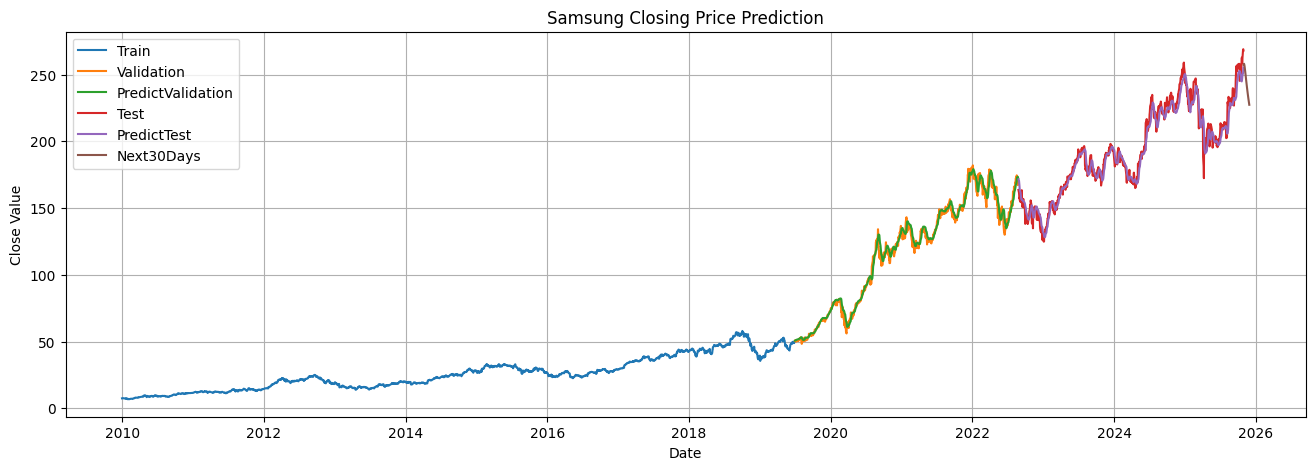

In [17]:
plt.figure(figsize=(16,5))
plt.plot(stock_apple.index[:train_size], train_data_inv)
plt.plot(stock_apple.index[train_size:train_size+val_size], val_data_inv)
plt.plot(stock_apple.index[train_size:train_size+val_size], y_pred_val)
plt.plot(stock_apple.index[train_size+val_size:], test_data_inv)
plt.plot(stock_apple.index[train_size+val_size:], y_pred_test)
plt.plot(future_dates, prediction_next30_days)
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.title('Samsung Closing Price Prediction')
plt.legend(['Train','Validation','PredictValidation','Test','PredictTest','Next30Days'])
plt.grid()
plt.show()